In [25]:
from importlib.metadata import version
import nltk
nltk.download('stopwords')
import tensorflow
import summa
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


3.6.5
2.6.0
1.3.3
1.2.0


### Step 1. 데이터 수집하기

In [14]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [15]:
data.sample(10)

,headlines,text
21861,VK Tahilramani becomes 3rd woman Chief Justice...,Justice Vijaya Kamlesh Tahilramani on Sunday w...
95377,US should not interfere in India's internal ma...,Following the US government's report denouncin...
76278,Will ask Centre to ban Blue Whale Game in coun...,The Kerala CM on Wednesday said that the state...
61769,Rajkummar Rao's 'Shaadi Mein Zaroor Aana' hits...,Rajkummar Rao starrer 'Shaadi Mein Zaroor Aana...
66085,Delhi Police suspends 400 licenses after ban o...,The Delhi Police on Tuesday suspended around 4...
2357,"Robot dog climbs steps, rings bell to deliver ...",German auto parts manufacturer Continental unv...
20946,Qatar accuses Saudi of blocking Hajj access to...,Qatar has accused Saudi Arabia of barring its ...
29268,"Fool around with older guys, Morgan asks journ...","In an old interview clip, Hollywood actor Morg..."
23759,DMK workers chant 'Yamraj Go Away' outside Kau...,The Dravida Munnetra Kazhagam (DMK) workers re...
9405,Anushka unveils her interactive statue at Mada...,Anushka Sharma unveiled her wax statue which i...


In [16]:
data.shape

(98401, 2)

### Step 2. 데이터 전처리하기 (추상적 요약)

#### 데이터 중복 및 공백 제거

In [17]:
#checking null values
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [18]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [19]:
# # inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


#### 텍스트 정규화와 불용어 제거

In [20]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [26]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [30]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # ,  등의 html 태그 제거
    sentence = re.sub(r'', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [31]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered wasfor my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start or finish the day


In [33]:
data['text'] = data['text'].apply(lambda x : preprocess_sentence(x))
print("text 전처리 후 결과: ", data['text'][:5])

text 전처리 후 결과:  0    saurav kant alumnus upgrad iiit pg program mac...
1    kunal shah credit card bill payment platform c...
2    new zealand defeated india wickets fourth odi ...
3    aegon life iterm insurance plan customers enjo...
4    speaking sexual harassment allegations rajkuma...
Name: text, dtype: object


In [34]:
data['headlines'] = data['headlines'].apply(lambda x : preprocess_sentence(x, False))
print("headlines 전처리 후 결과: ", data['headlines'][:5])

headlines 전처리 후 결과:  0    upgrad learner switches to career in ml al wit...
1    delhi techie wins free food from swiggy for on...
2    new zealand end rohit sharma led india match w...
3    aegon life iterm insurance plan helps customer...
4    have known hirani for yrs what if metoo claims...
Name: headlines, dtype: object


In [35]:
# 데이터 전처리 후 빈 값을 Null 값으로 변환 및 확인
data.replace('', np.nan, inplace=True)
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [36]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


text 최소 길이 : 1
text 최대 길이 : 60
text 평균 길이 : 35.27817202114681
headlines 최소 길이 : 1
headlines 최대 길이 : 16
headlines 평균 길이 : 9.299755998373323


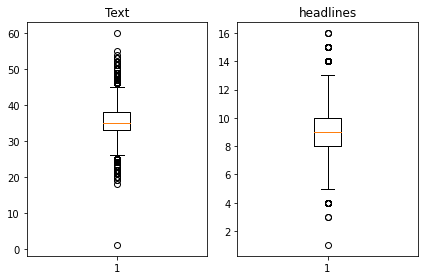

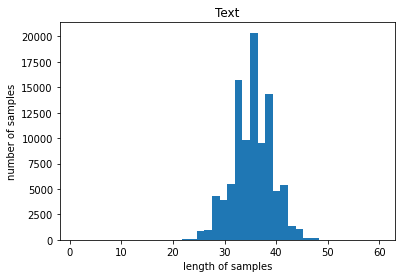

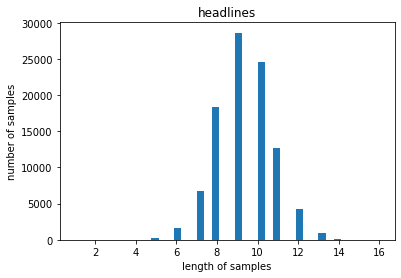

In [43]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('text 최소 길이 : {}'.format(np.min(text_len)))
print('text 최대 길이 : {}'.format(np.max(text_len)))
print('text 평균 길이 : {}'.format(np.mean(text_len)))
print('headlines 최소 길이 : {}'.format(np.min(summary_len)))
print('headlines 최대 길이 : {}'.format(np.max(summary_len)))
print('headlines 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [53]:
text_max_len = 40
summary_max_len = 10

In [54]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [55]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9170699471329808
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162667751118341


In [57]:
# 최대 길이 설정
text_max_len = 40
summary_max_len = 10

# 길이 조건을 만족하는 샘플만 선택
filtered_df = data[
    (data['text'].apply(lambda x: len(x.split()) <= text_max_len)) &
    (data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len))
]

# 결과 확인
print(f"원본 데이터 크기: {len(data)}")
print(f"필터링 후 데이터 크기: {len(filtered_df)}")
print(f"제거된 샘플 수: {len(data) - len(filtered_df)}")

원본 데이터 크기: 98360
필터링 후 데이터 크기: 73552
제거된 샘플 수: 24808


In [58]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
filtered_df['decoder_input'] = filtered_df['headlines'].apply(lambda x : 'sostoken '+ x)
filtered_df['decoder_target'] = filtered_df['headlines'].apply(lambda x : x + ' eostoken')
filtered_df.head()

/tmp/ipykernel_69/3375523477.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['decoder_input'] = filtered_df['headlines'].apply(lambda x : 'sostoken '+ x)
/tmp/ipykernel_69/3375523477.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['decoder_target'] = filtered_df['headlines'].apply(lambda x : x + ' eostoken')


,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


In [59]:
encoder_input = np.array(filtered_df['text']) # 인코더의 입력
decoder_input = np.array(filtered_df['decoder_input']) # 디코더의 입력
decoder_target = np.array(filtered_df['decoder_target']) # 디코더의 레이블

In [60]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[52702 33361 71013 ... 58128 25827 67435]


In [61]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [62]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 14710


In [63]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 58842
훈련 레이블의 개수 : 58842
테스트 데이터의 개수 : 14710
테스트 레이블의 개수 : 14710


In [64]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [66]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 61725
등장 빈도가 6번 이하인 희귀 단어의 수: 42385
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19340
단어 집합에서 희귀 단어의 비율: 68.66747671121912
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.225925933180423


In [67]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [68]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[14, 355, 2251, 3722, 80, 128, 6967, 31, 14, 124, 1143, 581, 3139, 1809, 14, 118, 47, 346, 173, 581, 1098, 5676, 2336, 711, 2138, 1309, 126, 461, 111, 3048, 40, 626, 581], [479, 9, 5756, 26, 490, 13, 3983, 40, 553, 34, 327, 153, 13, 605, 1091, 9, 473, 281, 2696, 13, 605, 179, 6850, 420, 3049, 281], [360, 363, 892, 3473, 283, 1344, 2481, 3091, 1, 127, 50, 4269, 3760, 283, 1344, 1077, 3091, 674, 18, 85, 2481, 127, 473]]


In [69]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [70]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27188
등장 빈도가 5번 이하인 희귀 단어의 수: 18149
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9039
단어 집합에서 희귀 단어의 비율: 66.75371487420921
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.99856489526329


In [71]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 257, 7, 420], [1, 74, 307, 270, 46, 6, 20], [1, 998, 3, 201, 795, 3, 1988, 28], [1, 20, 172, 10, 124, 957, 11, 1186, 143], [1, 290, 288, 919, 893, 651, 38, 28]]
target
decoder  [[257, 7, 420, 2], [74, 307, 270, 46, 6, 20, 2], [998, 3, 201, 795, 3, 1988, 28, 2], [20, 172, 10, 124, 957, 11, 1186, 143, 2], [290, 288, 919, 893, 651, 38, 28, 2]]


In [72]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 11
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 58831
훈련 레이블의 개수 : 58831
테스트 데이터의 개수 : 14709
테스트 레이블의 개수 : 14709


In [73]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

In [74]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

In [75]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [76]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
230/230 [==============================] - 58s 61ms/step - loss: 4.4335 - val_loss: 4.1351
Epoch 2/50
230/230 [==============================] - 13s 56ms/step - loss: 3.9955 - val_loss: 3.8510
Epoch 3/50
230/230 [==============================] - 13s 57ms/step - loss: 3.7407 - val_loss: 3.6249
Epoch 4/50
230/230 [==============================] - 13s 58ms/step - loss: 3.5079 - val_loss: 3.4294
Epoch 5/50
230/230 [==============================] - 13s 58ms/step - loss: 3.3120 - val_loss: 3.2981
Epoch 6/50
230/230 [==============================] - 14s 59ms/step - loss: 3.1692 - val_loss: 3.1911
Epoch 7/50
230/230 [==============================] - 14s 60ms/step - loss: 3.0533 - val_loss: 3.1146
Epoch 8/50
230/230 [==============================] - 14s 60ms/step - loss: 2.9543 - val_loss: 3.0601
Epoch 9/50
230/230 [==============================] - 14s 60ms/step - loss: 2.8668 - val_loss: 3.0075
Epoch 10/50
230/230 [==============================] - 14s 60ms/step - loss: 2.788

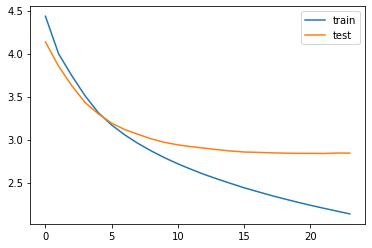

In [77]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [78]:
# 인퍼런스 모델 구현
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [79]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [80]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [81]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # 에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [82]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        if i != 0 and i != tar_word_to_index['sostoken'] and i != tar_word_to_index['eostoken']:
            temp = temp + tar_index_to_word[i] + ' '
    return temp.strip()

### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [83]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : former oscar injured prison brawl use public phone december officials said tuesday serving year jail term murder girlfriend fight started prisoners reportedly conversation 
실제 요약 : former injured in prison
예측 요약 :  ex man attacked for in


원문 : akshay kumar turned sunday said forget still thinking times action added take stress number head turning still feel lot fun still feel run fast feel like jumping 
실제 요약 : am still think am in my times akshay
예측 요약 :  my career is my career akshay kumar


원문 : anil ambani led reliance communications rcom shut direct home business operating reliance digital tv effective november reliance digital tv smallest player market share cited licence reason closure rcom said working three operators customers 
실제 요약 : rcom to shut down its operations from
예측 요약 :  rcom shares up to buy rcom


원문 : cabinet committee sent cbi director alok verma special director rakesh leave appointed rao interim director agency new delhi headquarters sealed select office

### Step 5. 추출적 요약

In [4]:
import requests
from summa.summarizer import summarize

In [5]:
data.sample(10)

,headlines,text
68376,Driver caught for speeding tells police he 'ne...,A truck driver who was driving 37 km/h over th...
62469,Delhi Metro to install solar panels on Kalkaji...,The Delhi Metro Rail Corporation (DMRC) has de...
80624,Tendulkar attends Wimbledon semi-final to supp...,Sachin Tendulkar was spotted at the Centre Cou...
57662,Most accusations behind Russia Olympic ban unf...,After the International Olympic Committee bann...
59705,Why is England-Australia Test series called 'T...,England was beaten at home for the first time ...
85339,GoogleÃ¢ÂÂs Gboard to now recognise hand-dra...,The latest update of Google's Android keyboard...
89445,Family adopts 7 siblings who were in foster ca...,"A family in Georgia, US adopted seven siblings..."
68712,Pacific 'flip' ends global warming 'slowdown':...,The 2014-2016 global mean temperatures broke r...
8338,We won as a team: Ben Stokes on Manjrekar's 'g...,After Indian cricketer-turned-commentator Sanj...
34396,Exporters' body writes to RBI for reintroducti...,The Federation of Indian Export Organisations ...


In [7]:
# 새로운 'summary' 컬럼을 저장할 리스트 생성
summaries = []

for idx in range(len(data)):
    # 현재 처리 중인 row 번호 출력
    print(f"Processing row {idx+1}/{len(data)}")
    
    # 본문 텍스트 요약
    summary = summarize(data.iloc[idx]['text'], ratio=0.4)
    summaries.append(summary)
    


# 'summary' 컬럼을 데이터프레임에 추가
data['summary'] = summaries

# 결과 확인
print(data.head())

Processing row 1/98401
Processing row 2/98401
Processing row 3/98401
Processing row 4/98401
Processing row 5/98401
Processing row 6/98401
Processing row 7/98401
Processing row 8/98401
Processing row 9/98401
Processing row 10/98401
Processing row 11/98401
Processing row 12/98401
Processing row 13/98401
Processing row 14/98401
Processing row 15/98401
Processing row 16/98401
Processing row 17/98401
Processing row 18/98401
Processing row 19/98401
Processing row 20/98401
Processing row 21/98401
Processing row 22/98401
Processing row 23/98401
Processing row 24/98401
Processing row 25/98401
Processing row 26/98401
Processing row 27/98401
Processing row 28/98401
Processing row 29/98401
Processing row 30/98401
Processing row 31/98401
Processing row 32/98401
Processing row 33/98401
Processing row 34/98401
Processing row 35/98401
Processing row 36/98401
Processing row 37/98401
Processing row 38/98401
Processing row 39/98401
Processing row 40/98401
Processing row 41/98401
Processing row 42/98401
P

In [9]:
data.head()

,headlines,text,summary
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad's Online Power Learning has powered 3 l...
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,Users get one CRED coin per rupee of bill paid...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,The match witnessed India getting all out for ...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...","Also, customers have options to insure against..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,Speaking about the sexual harassment allegatio...
